In [3]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import FuncAnimation
import os
import pickle
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
import pdspy.modeling as modeling

%matplotlib inline

In [4]:
# get all model data
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)   

In [5]:
# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-42]=np.nan

In [6]:
feat=[5,16,35,36]
noise=[12,25,45,71]
both=[0,8,46,62,68]

In [7]:
def ps(data):
    ps = np.abs(np.fft.fft(data))**2
    time_step = 1 / 300
    freqs = np.fft.fftfreq(data.size, time_step)
    index = np.argsort(freqs)
    plt.figure(figsize=(12,9))
    plt.plot(freqs[index], np.log10(ps[index]))
    plt.axhline(2,c='r',linestyle=':',alpha=0.5)
    plt.xlim(-1,150)
    plt.ylim(0,8)

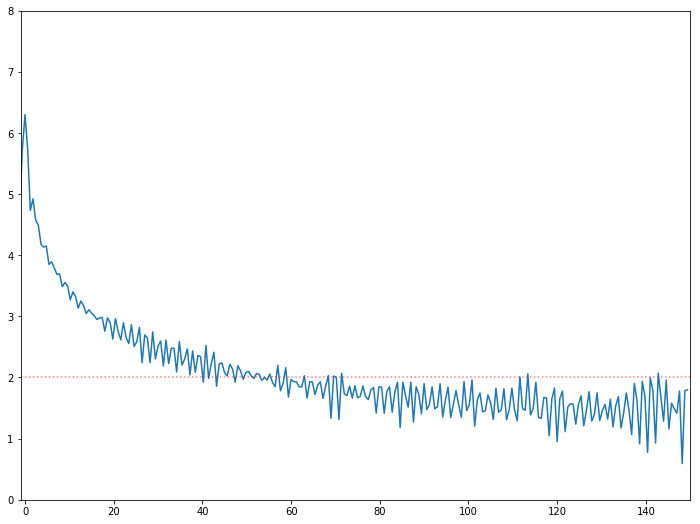

In [8]:
ps(cube[71])

In [9]:
def gausskern(size): # size = 2* standard deviation
    arr=Gaussian1DKernel(size/2).array
    return arr

def tophatkern(size): # size = width of tophat
    arr=[]
    height=1.0/size
    for i in range(size):
        arr.append(height)
    return arr

featlim=np.log10([2.65,3.5,7.2,15.5])
featlimindex=[]
for i in range(len(featlim)):
    val=min(np.log10(xvals), key=lambda x:abs(x-featlim[i]))
    featlimindex.append(np.where(np.log10(xvals)==val)[0][0])

In [10]:
def extend_smooth_cut(data,kernsize,kernstyle,a1=5,a2=5):
    if kernstyle=='g':
        extras=[round(kernsize*2),round(kernsize*2)]
        kernel=gausskern(kernsize)
    if kernstyle=='t':
        extras=[(kernsize//2),((kernsize-1)//2)]
        kernel=tophatkern(kernsize)
        
    leftm=(data[a1]-data[0])/a1
    rightm=(data[-1]-data[-1-a2])/a2
    
    extended_data=[]
    for i in range(extras[0]):
        extended_data.append(leftm*(i-extras[0])+data[0])
    extended_data+=np.ndarray.tolist(np.array(data))
    for i in range(extras[1]):
        extended_data.append(rightm*(i+1)+data[-1])
    smoothed=np.convolve(extended_data,kernel,mode="valid")
    return smoothed

In [11]:
def piece(data,ckern,ckernsize,wkern,wkernsize,skern,skernsize,aout,ain):
    fig,ax=plt.subplots(1,figsize=(16,12))
    
    smooth=[]    
    smooth+=np.ndarray.tolist(np.array(extend_smooth_cut(data[:featlimindex[0]],ckernsize,ckern,a1=aout,a2=aout)))
    smooth+=np.ndarray.tolist(np.array(extend_smooth_cut(data[featlimindex[0]:featlimindex[1]+1],wkernsize,wkern,a1=ain,a2=ain)))
    smooth+=np.ndarray.tolist(np.array(extend_smooth_cut(data[featlimindex[1]+1:featlimindex[2]],ckernsize,ckern,a1=aout,a2=aout)))
    smooth+=np.ndarray.tolist(np.array(extend_smooth_cut(data[featlimindex[2]:featlimindex[3]+1],skernsize,skern,a1=ain,a2=ain)))
    smooth+=np.ndarray.tolist(np.array(extend_smooth_cut(data[featlimindex[3]+1:],ckernsize,ckern,a1=aout,a2=aout)))
    
    # water feature -- there are features in water ice spectrum at 2.941 and 3.105 microns
    plt.axvline(x=np.mean([np.log10(2.941),np.log10(3.105)]),c='r',linestyle=":",alpha=0.7,label="H20 feature")
    plt.axvline(x=np.log10(2.65),c='b',linestyle=":",alpha=0.7)
    plt.axvline(x=np.log10(3.5),c='b',linestyle=":",alpha=0.7)
    # silicate feature at 10 microns
    plt.axvline(x=np.log10(10.),c='r',linestyle="--",alpha=0.7,label="silicate feature")    
    plt.axvline(x=np.log10(7.2),c='b',linestyle="--",alpha=0.7)
    plt.axvline(x=np.log10(15.5),c='b',linestyle="--",alpha=0.7)
    
    ax.plot(np.log10(xvals), data,c='black',label="original SED",alpha=0.6)    
    ax.plot(np.log10(xvals), smooth,c='red',label="smoothed SED",alpha=0.8)
    
    #plt.xlim(0.2,1.4) # keep it to the features
    plt.legend()
    plt.ylabel("log of Flux Density (mJy)")
    plt.xlabel("log of λ (μm)")
    plt.show()

5


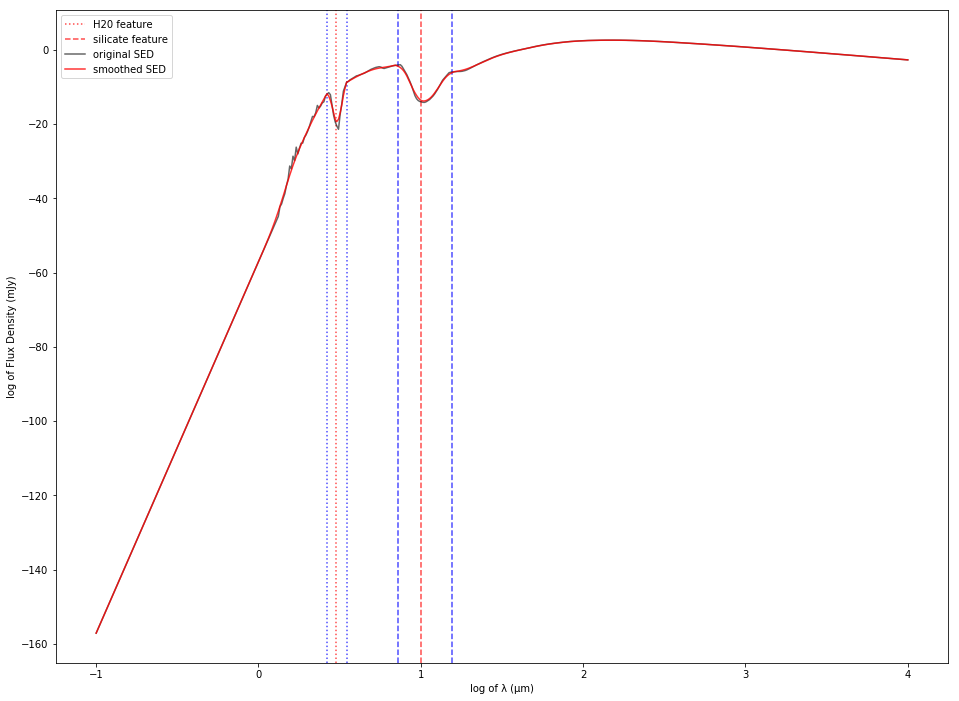

16


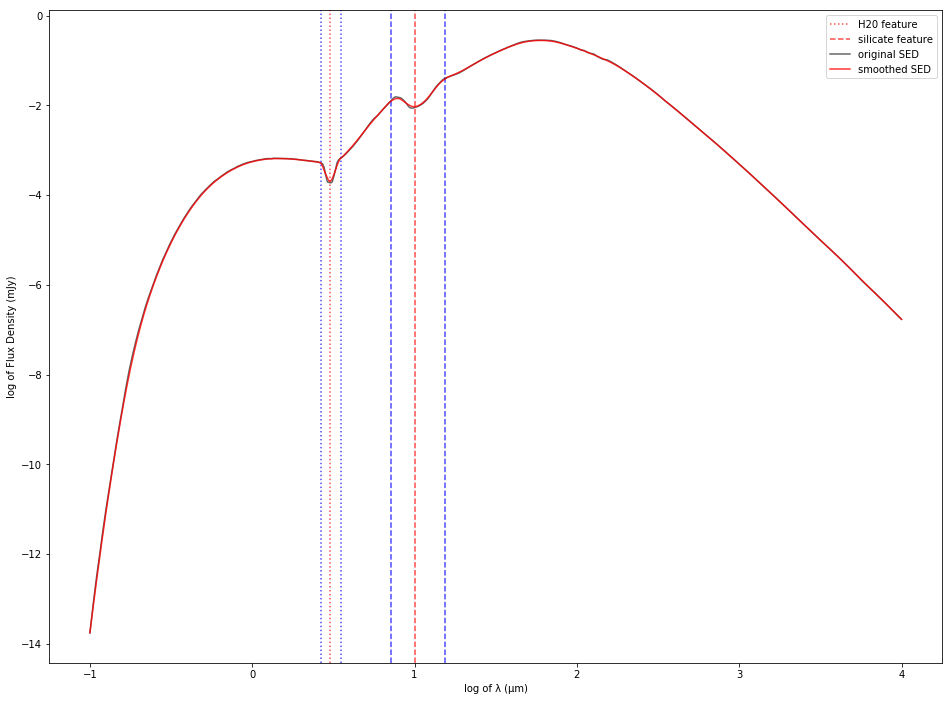

35


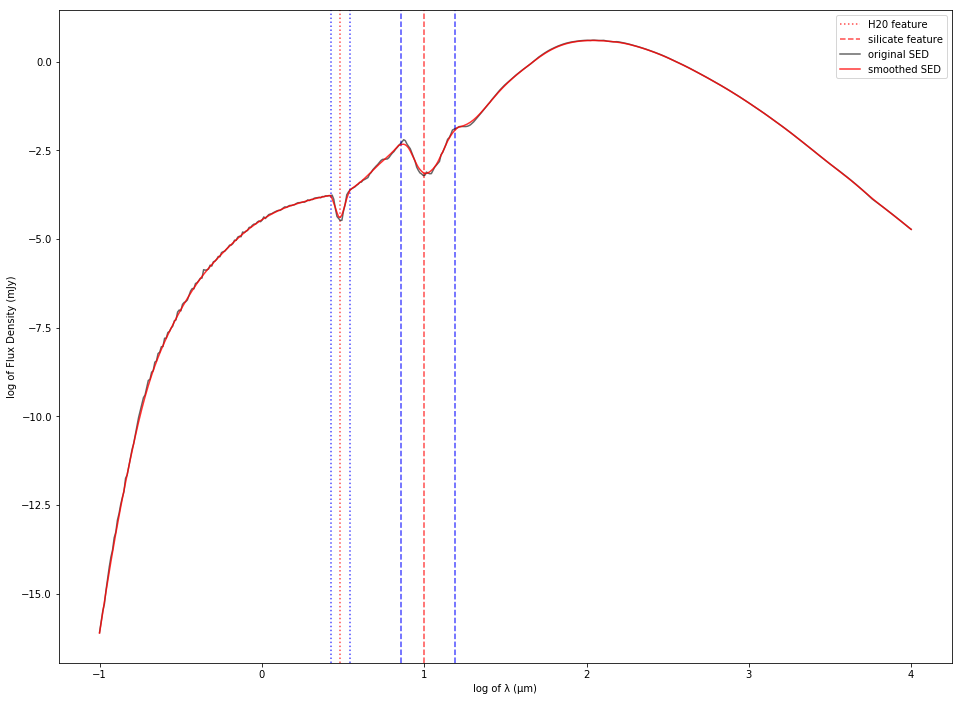

36


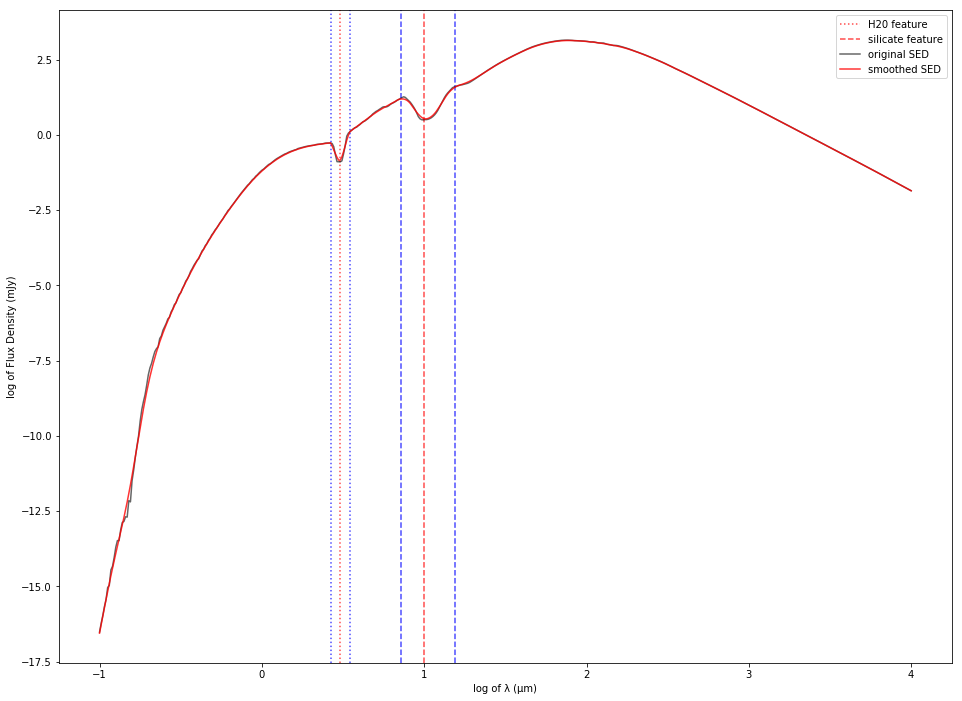

0


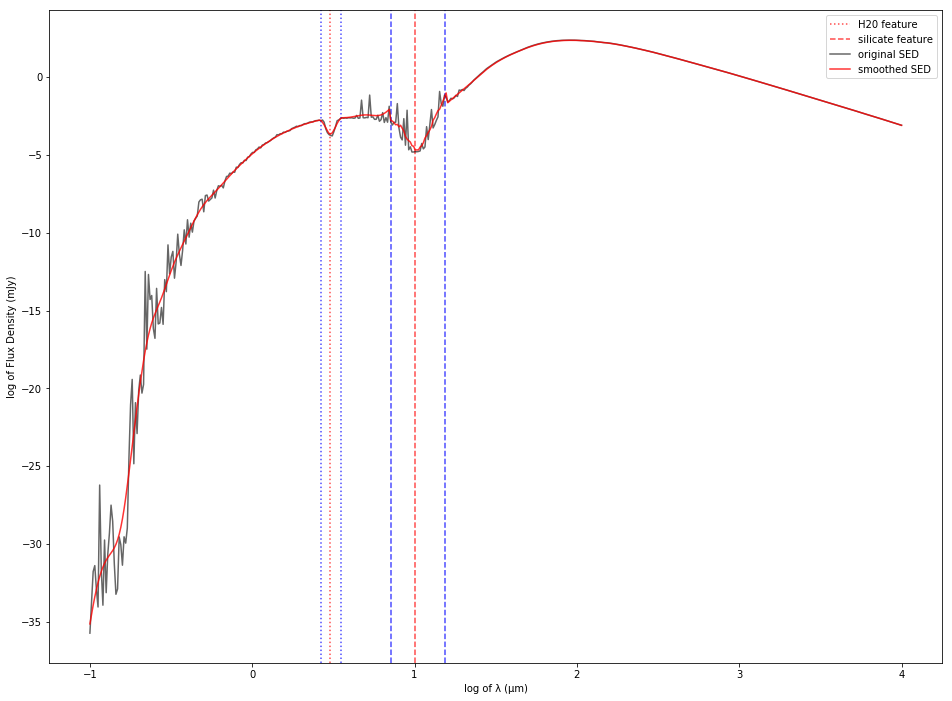

8


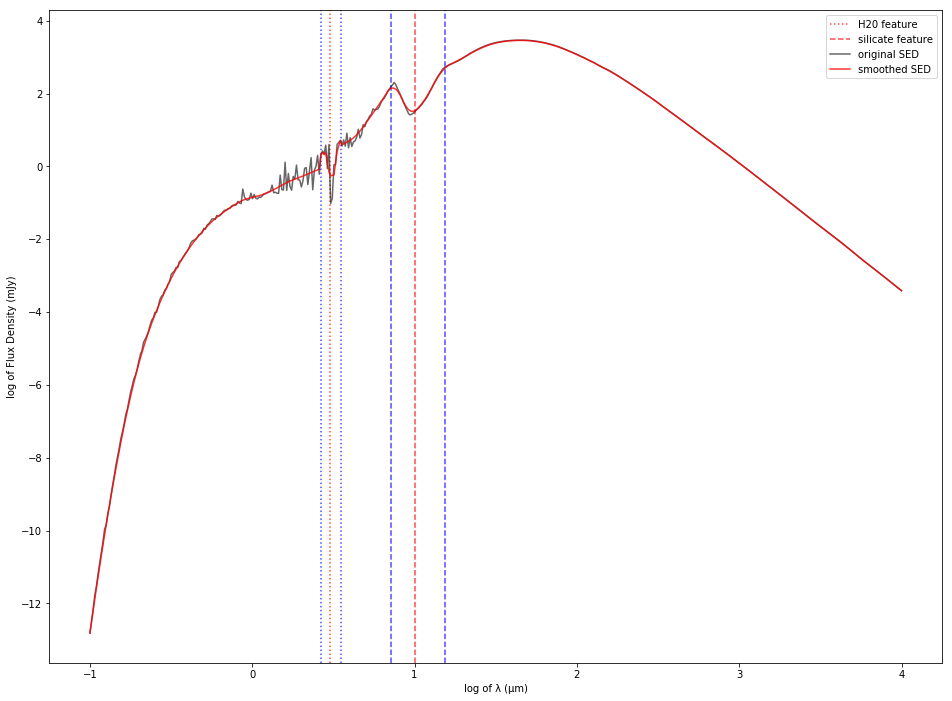

46


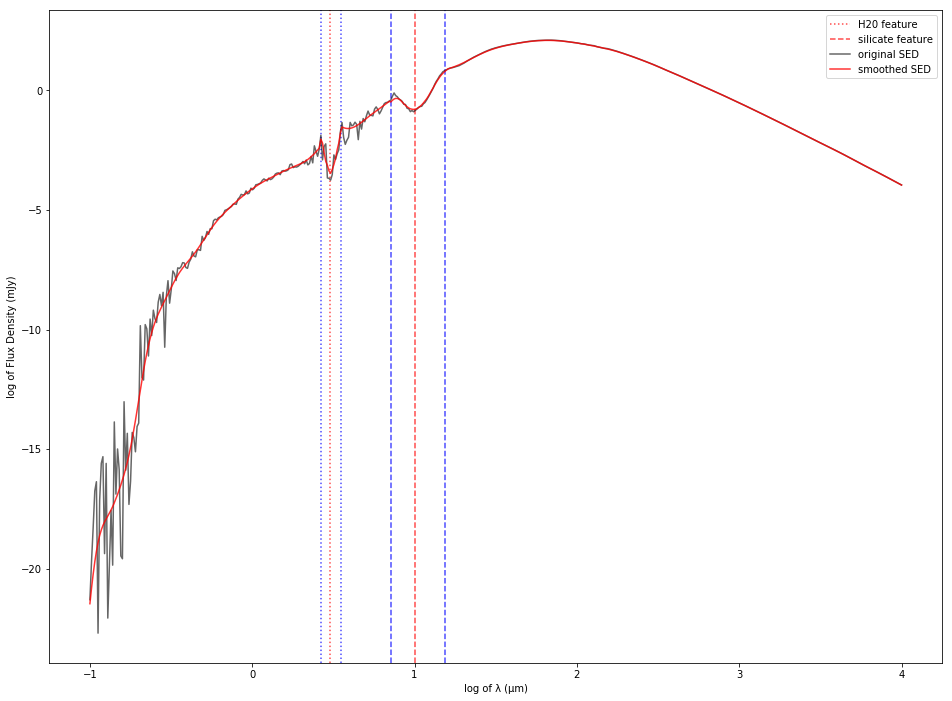

62


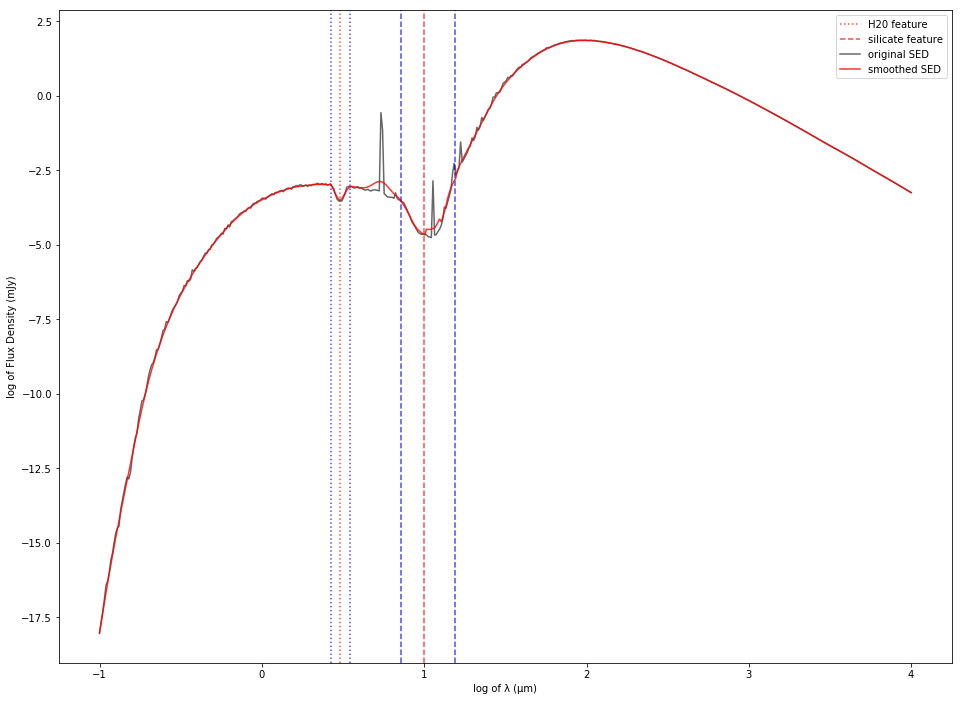

68


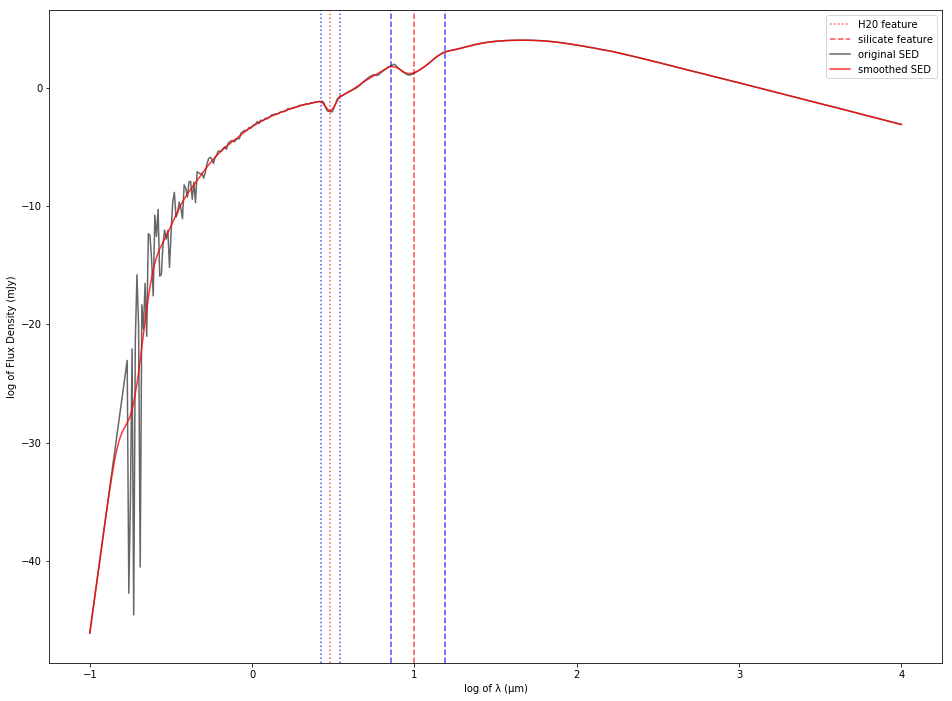

In [12]:
ds=noise
#for i in range(len(ds)):
    #print(ds[i])
    #piece(cube[ds[i]],"g",10,"t",5,"t",9,aout=7,ain=2)
ds=feat
for i in range(len(ds)):
    print(ds[i])
    piece(cube[ds[i]],"g",10,"t",5,"t",9,aout=7,ain=2)
ds=both
for i in range(len(ds)):
    print(ds[i])
    piece(cube[ds[i]],"g",10,"t",5,"t",9,aout=7,ain=2)

In [13]:
def resids(data,ckern,ckernsize,wkern,wkernsize,skern,skernsize,aout,ain):
  
    smooth=[]    
    smooth+=np.ndarray.tolist(np.array(extend_smooth_cut(data[:featlimindex[0]],ckernsize,ckern,a1=aout,a2=aout)))
    smooth+=np.ndarray.tolist(np.array(extend_smooth_cut(data[featlimindex[0]:featlimindex[1]+1],wkernsize,wkern,a1=ain,a2=ain)))
    smooth+=np.ndarray.tolist(np.array(extend_smooth_cut(data[featlimindex[1]+1:featlimindex[2]],ckernsize,ckern,a1=aout,a2=aout)))
    smooth+=np.ndarray.tolist(np.array(extend_smooth_cut(data[featlimindex[2]:featlimindex[3]+1],skernsize,skern,a1=ain,a2=ain)))
    smooth+=np.ndarray.tolist(np.array(extend_smooth_cut(data[featlimindex[3]+1:],ckernsize,ckern,a1=aout,a2=aout)))
    
    return data-smooth

In [14]:
res=resids(cube[both[4]],"g",10,"t",5,"t",9,aout=7,ain=2)

In [15]:
np.std(res[0:50])

5.022874616558638

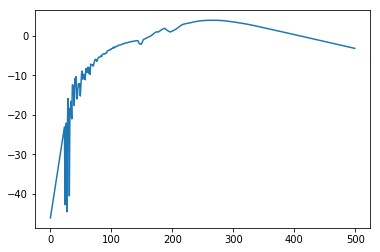

In [16]:
plt.plot(cube[both[4]])

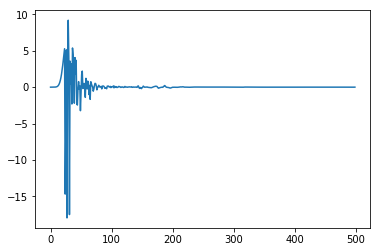

In [17]:
plt.plot(res)